In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

#libraries for EDA & EDA preprocessing
from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline



#libraries for ML preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#libraries for evaluation
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split

#libraries for models
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install yellowbrick

In [9]:
"""Load DataFrame"""
df = pd.read_csv('cleaned_data.csv', encoding='latin-1')
df = pd.DataFrame(df)
df.head()

,Id,city,History,Millage,Ratings,Year,Make,Model,Transmission,Age,Price
0,0,Abia,foreign,149232,4.7,2015,Honda,Accord,Automatic,5,4965000
1,1,Accra,local,145078,4.4,2005,Toyota,Corolla,Automatic,15,1280000
2,2,Accra,local,91691,4.6,2008,Toyota,Corolla,Automatic,12,1280000
3,3,Lagos,local,234797,4.5,2004,Toyota,Corolla,Automatic,16,1567500
4,4,Lagos,foreign,145678,4.8,2013,Hyundai,Azera,Automatic,7,6065000


# Pre-processing

## Dealing with missing values

In [10]:
df.isnull().sum() #return series of columns with respective of number of null values

Id                  0
city                0
History             0
Millage             0
Ratings         13189
Year                0
Make                0
Model               0
Transmission        0
Age                 0
Price               0
dtype: int64

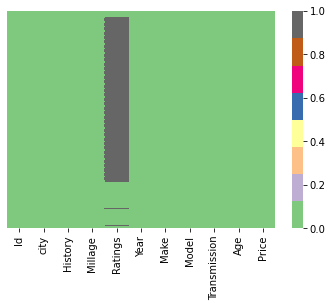

In [12]:
#heatmap to identify nulll values using graph
sns.heatmap(df.isnull(),yticklabels=False,cbar=True,cmap='Accent')

In [13]:
#define numeric variable and categorical variable to work separatly on them
num_col=['Millage','Ratings','Year','Age']
cat_cols=['city','History','Make','Model','Transmission']

## Estimating better iterative imputer method

In [15]:
check_imputer = df.copy()
check_imputer = check_imputer.drop(columns=['Id'])

#object of LabelEncoder
encoder = preprocessing.LabelEncoder()

#function to label the categorical columns ignoring null values 
def encode(data):
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#loop to label each column or categorical values into numberic
for i in tqdm(range(len(cat_cols))):
    encode(check_imputer[cat_cols[i]])

100%|██████████| 5/5 [00:00<00:00, 46.58it/s]


In [16]:
check_imputer.head()

,city,History,Millage,Ratings,Year,Make,Model,Transmission,Age,Price
0,0,0,149232,4.7,2015,63,96,0,5,4965000
1,3,1,145078,4.4,2005,146,195,0,15,1280000
2,3,1,91691,4.6,2008,146,195,0,12,1280000
3,17,1,234797,4.5,2004,146,195,0,16,1567500
4,17,0,145678,4.8,2013,65,112,0,7,6065000


In [17]:
# Estimate the score on the entire dataset by filling missing values by mean and median

br_estimator = BayesianRidge() #base estimator
N_SPLITS = 6  #defining the cross-validation splitting strategy

score_simple_imputer = pd.DataFrame() #dataframe to store error of imputer

#computing MSE for mean and median
for strategy in ('mean', 'median'):
    X=check_imputer.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
    y = np.ravel(check_imputer.iloc[:,-1:])
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X, y, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

In [18]:
# Estimate the score on the entire dataset by filling missing values by 4 different iterative imputer


#estimators for IterativeImputer
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for esti in estimators:
        print("Estimating",esti.__class__.__name__)
        imputer = IterativeImputer(esti)
        df_new=check_imputer.copy()
        for col in check_imputer.columns:
            impute_data = imputer.fit_transform(df_new[col].values.reshape(-1,1))
            impute_data = impute_data.astype('int64')
            impute_data = pd.DataFrame(np.ravel(impute_data))
            df_new[col] = impute_data
        X = df_new.iloc[:,:-1]
        y = np.ravel(df_new.iloc[:,-1:])
        score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti,X,y,scoring='neg_mean_squared_error',cv=6)

Estimating BayesianRidge
Estimating DecisionTreeRegressor
Estimating ExtraTreesRegressor
Estimating KNeighborsRegressor


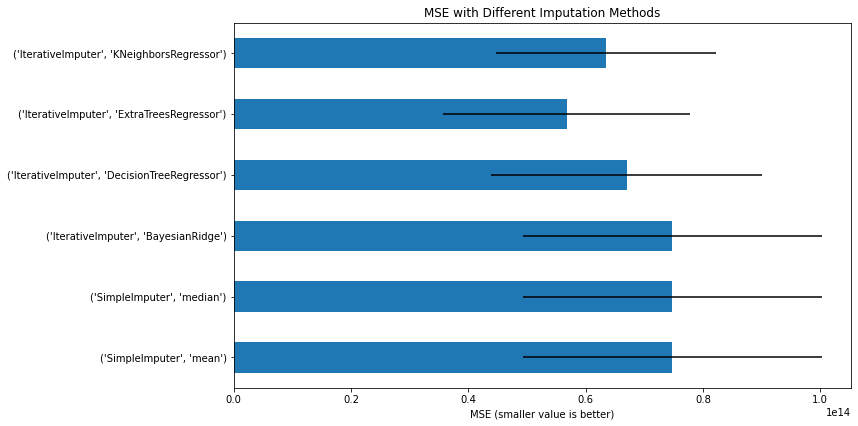

In [19]:
#ploting the graphs of scores each method

scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)

fig, ax = plt.subplots(figsize=(12, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('MSE with Different Imputation Methods')
ax.set_xlabel('MSE (smaller value is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels(means.index.tolist())
plt.tight_layout(pad=1)
plt.savefig('different-imputations-method',dpi=None)
plt.show()

In [20]:
#Filling Numerical Missing Values

df.isnull().sum()[num_col]

Millage        0
Ratings    13189
Year           0
Age            0
dtype: int64

In [21]:
data_num = df[num_col]
imputer_num = IterativeImputer(estimators[2])
impute_data = imputer_num.fit_transform(data_num)
df[num_col] = impute_data

#Missing values after filling
df.isnull().sum()[num_col]

Millage    0
Ratings    0
Year       0
Age        0
dtype: int64

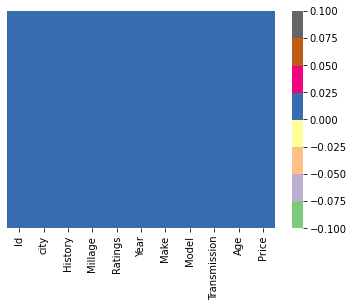

In [22]:
#Heat map checking values visually
sns.heatmap(df.isnull(),yticklabels=False,cbar=True,cmap='Accent')

### Outlier Detection

In [25]:
from IPython.display import display, Latex
outliers_condi = Latex(r" $\textbf{W𝑒 𝑐𝑎𝑛 𝑠𝑎𝑦 $𝑥_1$ or $x_2$ 𝑖𝑠 𝑜𝑢𝑡𝑙𝑖𝑒𝑟𝑠 if }\\ x_1 < Q1 - 1.5*IQR \\ or\\ x_2 > Q3+1.5*IQR $")
outliers_info = Latex(r"$L_{p} = \frac{p}{100}(n+1) = i_p.f_p \\ where \,\, i_p \,\, is \,\, integer \,\, part \,\, of \,\, L_p \,\, and \,\, f_p \,\, is \,\, fractional \,\, part \,\, of \,\, L_p \\ Q1 = Y_{25} = x_{i_p} + f_p*(x_{i_{p+1}}-x_{i_p}) \\ Q3 = Y_{75} = x_{i_p} + f_p*(x_{i_{p+1}}-x_{i_p}) \\ IQR = Q3-Q1 \\ x_1 = Q1 - 1.5*IQR \,\,and\,\, x_2 = Q3+1.5*IQR $")

display(outliers_info)
display(outliers_condi)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [26]:
#it will return the range of the variables and the values outside this range will be outliers

def outliers(arr,col):
    x = sorted(arr[col].values.ravel())
    L_25 = 25/100*(len(x)+1) #L_p where p=25%
    i_p = int(str(L_25).split(".")[0])
    f_p = int(str(L_25).split(".")[1])
    q1=x[i_p]+f_p*(x[i_p+1]-x[i_p])
    
    L_75 = 75/100*(len(x)+1) #L_p where p=75%
    i_p = int(str(L_75).split(".")[0])
    f_p = int(str(L_75).split(".")[1])
    q3 = x[i_p]+f_p*(x[i_p+1]-x[i_p])

    IQR = q3-q1
    x1 = q1-1.5*IQR
    x2 = q3+1.5*IQR
    
    return (x1,x2)

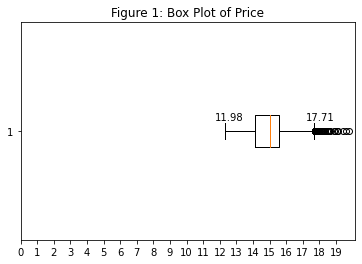

In [29]:
#Box Plot of Price

def min_max_price(df):
    r=[]
    q1,q3=(df['logprice'].quantile([0.25,0.75]))
    r.append(q1-1.5*(q3-q1))
    r.append(q3+1.5*(q3-q1))
    return (r)

df['logprice'] = np.log(df['Price'])
x = df['logprice']
price_range = list(range(0,int(max(df['logprice']))+1))
red_square = dict(markerfacecolor='g', marker='s')
plt.boxplot(x, vert=False)
plt.xticks(price_range)
plt.text(min_max_price(df)[0]-0.3,1.05,str(round(min_max_price(df)[0],2)))
plt.text(min_max_price(df)[1]-0.5,1.05,str(round(min_max_price(df)[1],2)))
plt.title("Figure 1: Box Plot of Price")
plt.savefig('graph-boxplot-price.jpg')
plt.show()

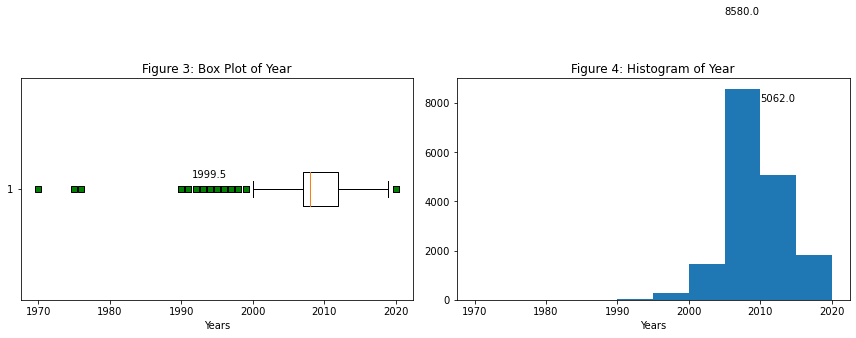

In [31]:
#Box Plot of Price

#ploting boxplot

fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,5))
o1, o2 = outliers(df,'Year')
ax1.boxplot(sorted(df['Year']), vert=False, flierprops=red_square)
ax1.set_xlabel("Years")
ax1.set_title("Figure 3: Box Plot of Year")
ax1.text(o1-8,1.05,str(round(o1,2)))

#ploting histogram
hist,bins=np.histogram(df['Year'])
n, bins, patches = ax2.hist(x = df['Year'], bins=bins)
ax2.set_xlabel("Years")
ax2.set_title("Figure 4: Histogram of Year")
for i in range(len(n)):
    if(n[i]>2000):
        ax2.text(bins[i],n[i]+3000,str(n[i]))

plt.tight_layout()
plt.savefig('graph-barplot-histogram-year.jpg',dpi=1200)
plt.show()

In [32]:
#Removing outliers 

df_new = df.copy()
out=np.array(['logprice','Year'])
for col in out:
    o1, o2 = outliers(df_new,col)
    df_new = df_new[(df_new[col]>=o1) & (df_new[col]<=o2)]
    print('IQR of',col,'=',o1,o2)
df_new = df_new[df_new['Price']!=0]
df_new.drop('logprice',axis=1,inplace=True)

IQR of logprice = 11.982655781692358 17.709763824657557
IQR of Year = 2001.0 2017.0


In [33]:
df_new.head()

,Id,city,History,Millage,Ratings,Year,Make,Model,Transmission,Age,Price
0,0,Abia,foreign,149232.0,4.7,2015.0,Honda,Accord,Automatic,5.0,4965000
1,1,Accra,local,145078.0,4.4,2005.0,Toyota,Corolla,Automatic,15.0,1280000
2,2,Accra,local,91691.0,4.6,2008.0,Toyota,Corolla,Automatic,12.0,1280000
3,3,Lagos,local,234797.0,4.5,2004.0,Toyota,Corolla,Automatic,16.0,1567500
4,4,Lagos,foreign,145678.0,4.8,2013.0,Hyundai,Azera,Automatic,7.0,6065000


In [34]:
print("Shape before process=",df.shape)
print("Shape After process=",df_new.shape)
diff = df.shape[0]-df_new.shape[0]
print("Total {} rows and {} cols removed".format(diff,df.shape[1]-df_new.shape[1]))
df_new.to_csv("vehiclesFinal.csv",index=False)

Shape before process= (17227, 12)
Shape After process= (13548, 11)
Total 3679 rows and 1 cols removed


# Exploratory Data Analysis

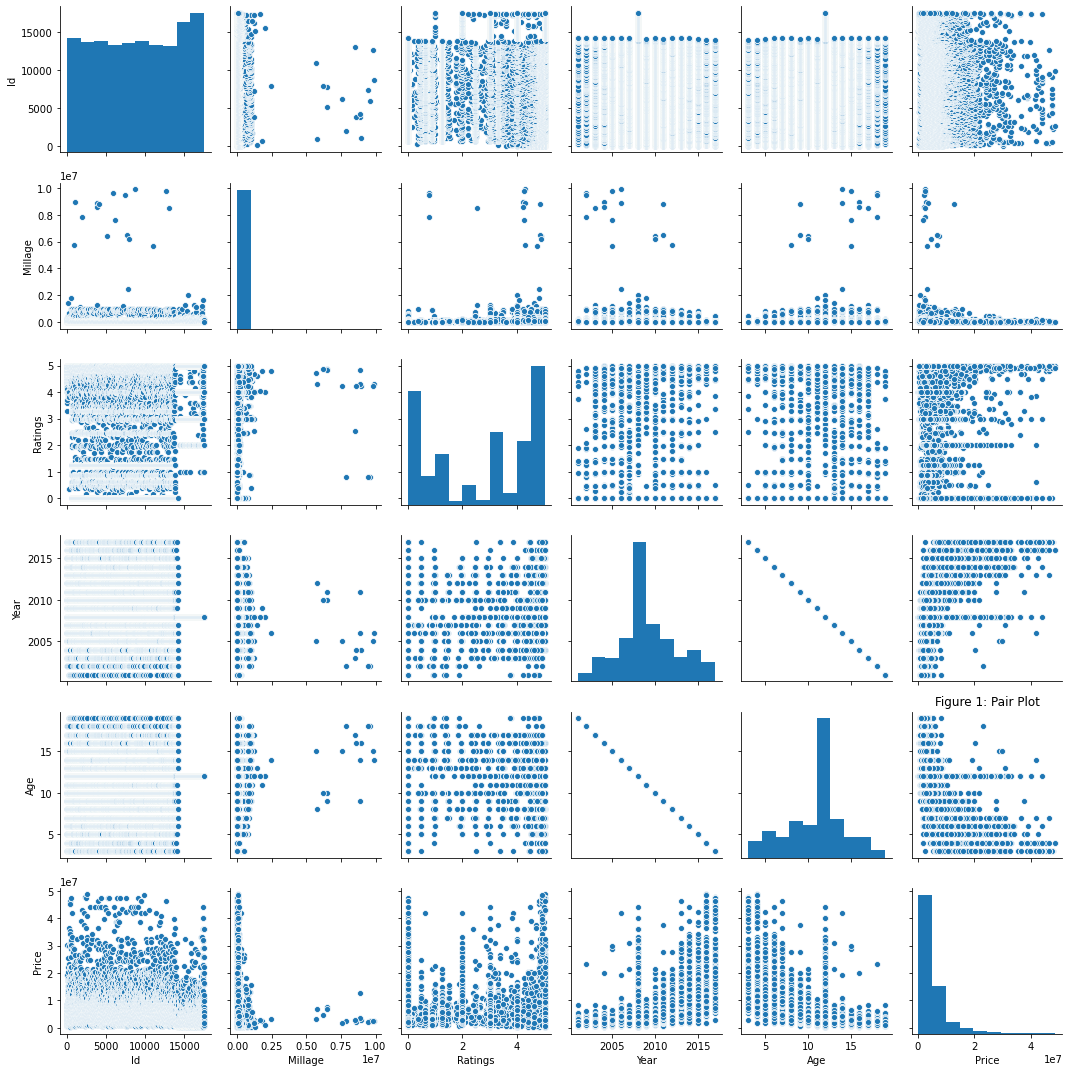

In [35]:
sns.pairplot(df_new)
plt.title('Figure 1: Pair Plot')
plt.tight_layout()
plt.savefig('Insight-Pair-Plot',dpi=None)
plt.show()

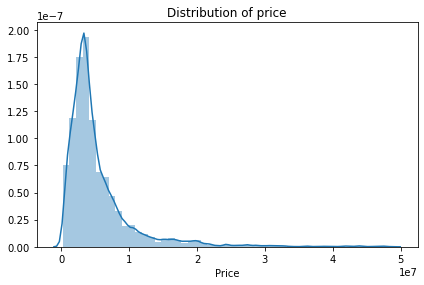

In [36]:
sns.distplot(df_new.Price)
plt.tight_layout()
plt.title("Distribution of price")
plt.savefig('Insight-Dist-Plot',dpi=None)
plt.show()

The Distribution of Price follows a Weibull probability density function

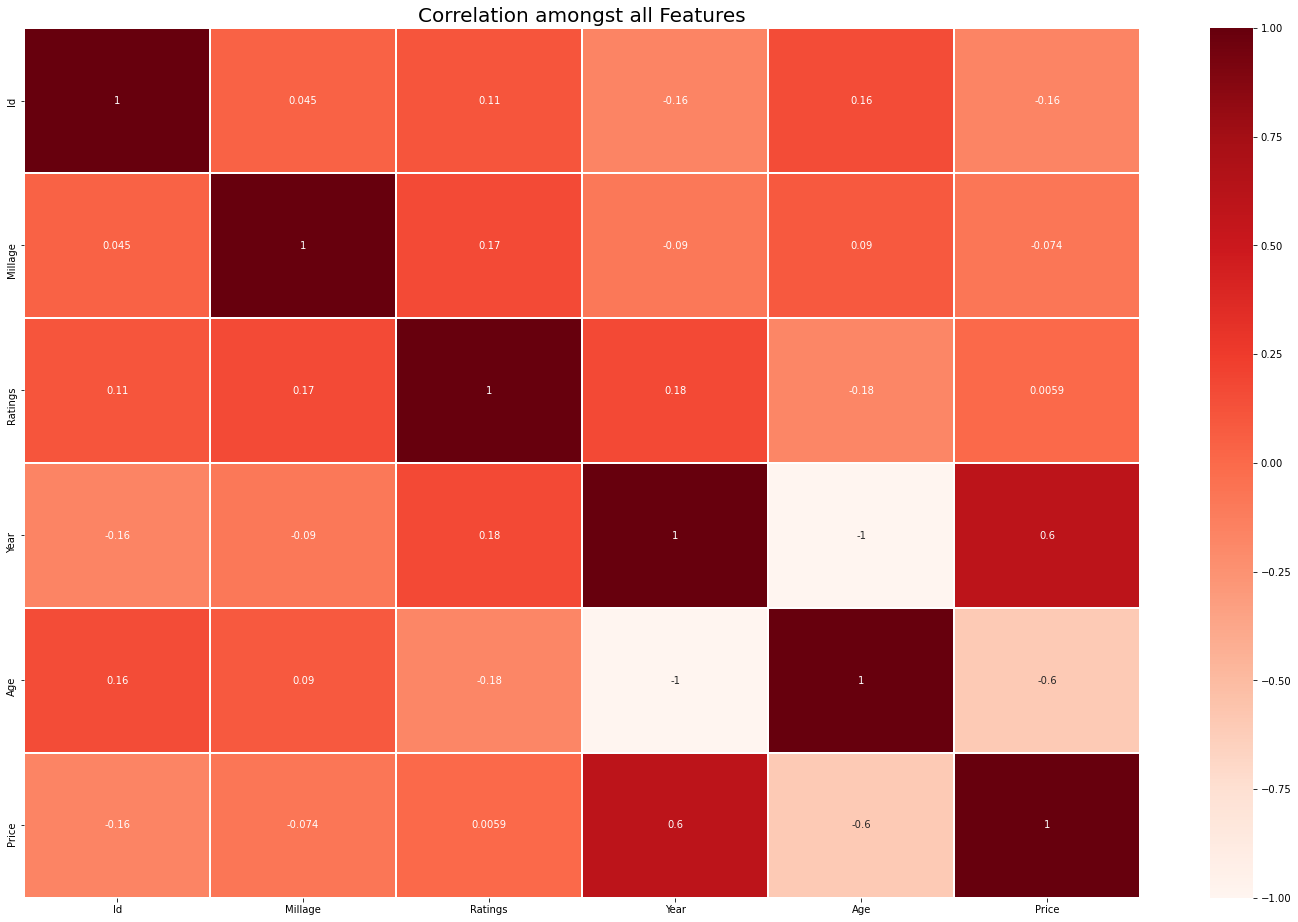

In [56]:
#Correlation Map of all Features in the dataset

plt.rcParams['figure.figsize']=(25,16)
hm=sns.heatmap(df_new.corr(), annot = True, linewidths=.5, cmap='Reds')
hm.set_title(label='Correlation amongst all Features', fontsize=20)
hm;

Correlation Map on all features the closer the values are to 1 the high there is a correlation between those features e.g Price and Year have a correlation of 0.6 meaning there's a positive relationship as the higher the Year, higher the price

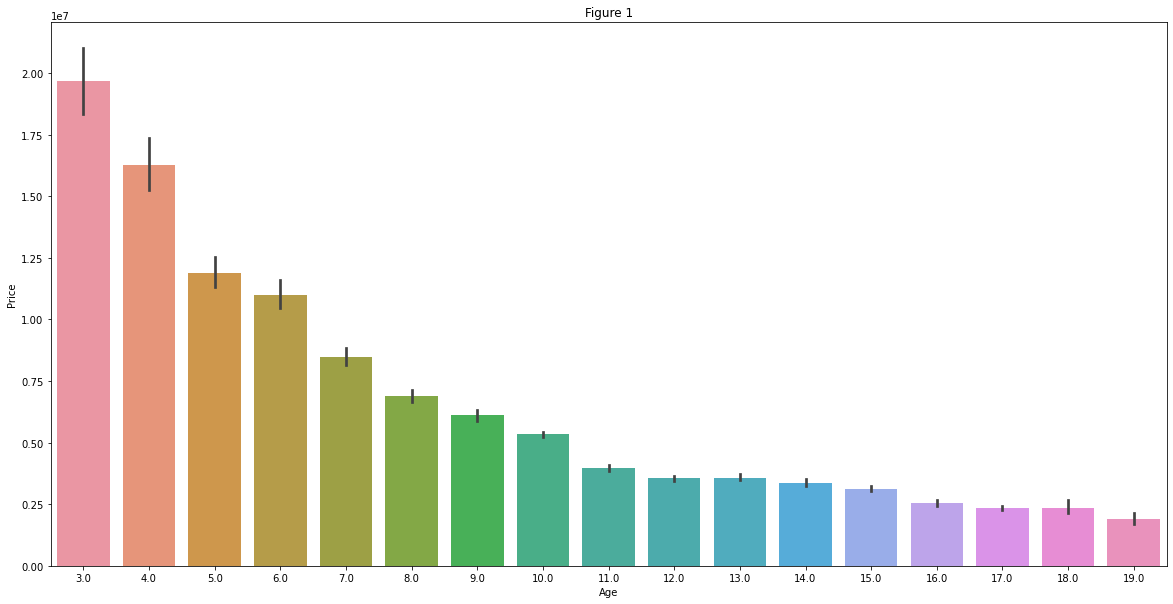

In [59]:
fig,axs=plt.subplots()
fig.set_size_inches(20,10)

p1=sns.barplot(x='Age',y='Price',data=df_new,ax=axs)
axs.set_title('Figure 1')

plt.savefig('Insight-Figure-1',dpi=None)
plt.show()

The earlier the car the pricier the car which is expected as older used cars have less value and it follows a Power Lognormal Distribution

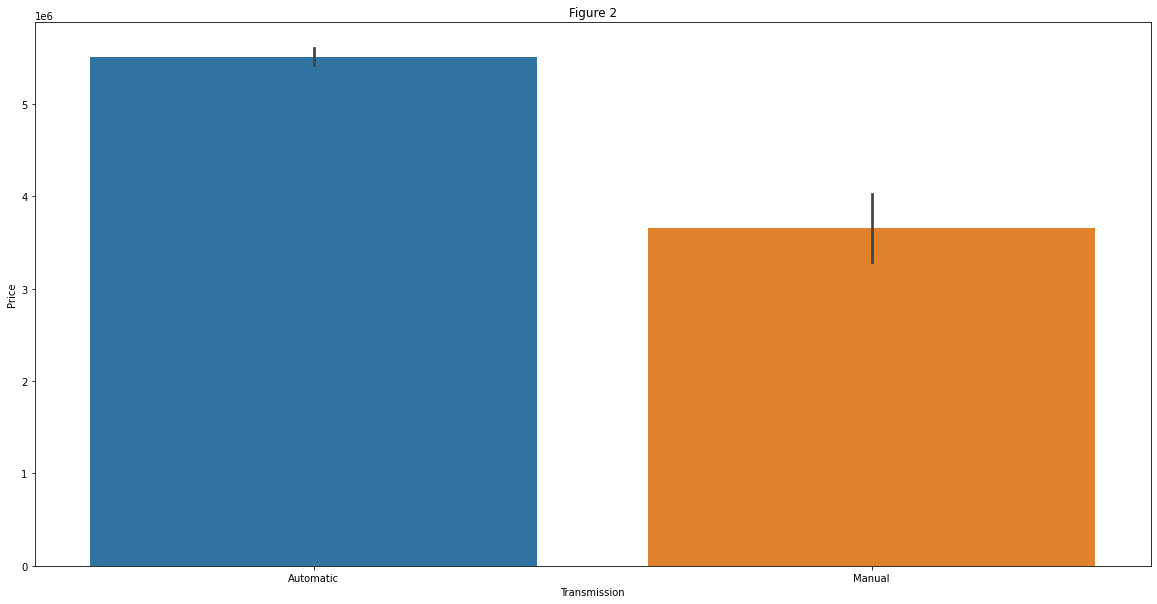

In [61]:
plt.figure(figsize=(20,10))
sns.barplot(x='Transmission',y='Price',data=df_new)
plt.title('Figure 2')
plt.savefig('Insight-Figure-2',dpi=None)
plt.show()

Automatic cars generally have a higher value as compared to Manual cars which is expected

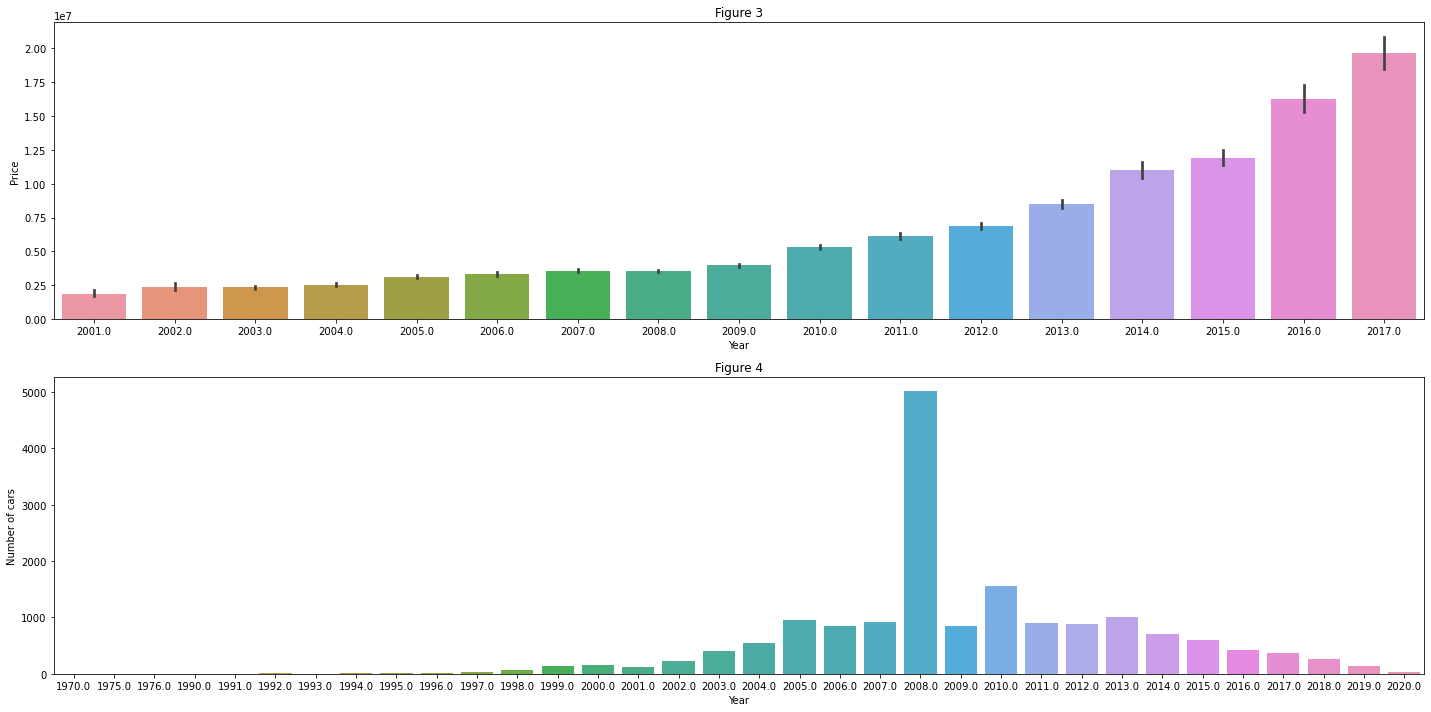

In [62]:
fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(20,10)
sns.barplot(x='Year',y='Price',data=df_new,ax=axs[0])
sns.barplot(df.groupby('Year').count()['Price'].index,df.groupby('Year').count()['Price'].values,ax=axs[1])
axs[0].set_title('Figure 3')
axs[1].set_title('Figure 4')
axs[1].set_ylabel('Number of cars')
plt.tight_layout()
plt.savefig('Insight-Figure-3-4.jpg',dpi=600)
plt.show()

In [79]:
df_new.Ratings.describe()

count    13548.000000
mean         2.674822
std          1.894488
min          0.000000
25%          0.635714
50%          3.000000
75%          4.700000
max          5.000000
Name: Ratings, dtype: float64

In [82]:
# Categorise Ratings into low, middle and high ratings
avg_rating = df.Ratings.mean()
filter_method = lambda x: 'high' if x > avg_rating else 'average' if (x == avg_rating) else 'low' if x < avg_rating else None
df['Ratings Category'] = df['Ratings'].apply(filter_method)
df['Ratings Category'].unique()

array(['high', 'low'], dtype=object)

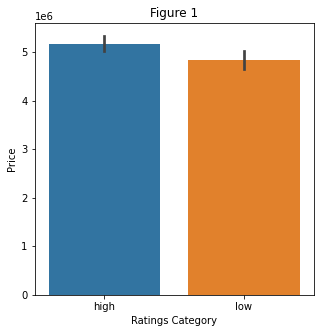

In [83]:
fig,axs=plt.subplots()
fig.set_size_inches(5,5)

p1=sns.barplot(x='Ratings Category',y='Price',data=df,ax=axs)
axs.set_title('Figure 1')

plt.savefig('Insight-Figure-5',dpi=None)
plt.show()

The higher the rating of the car the higher the price of the car

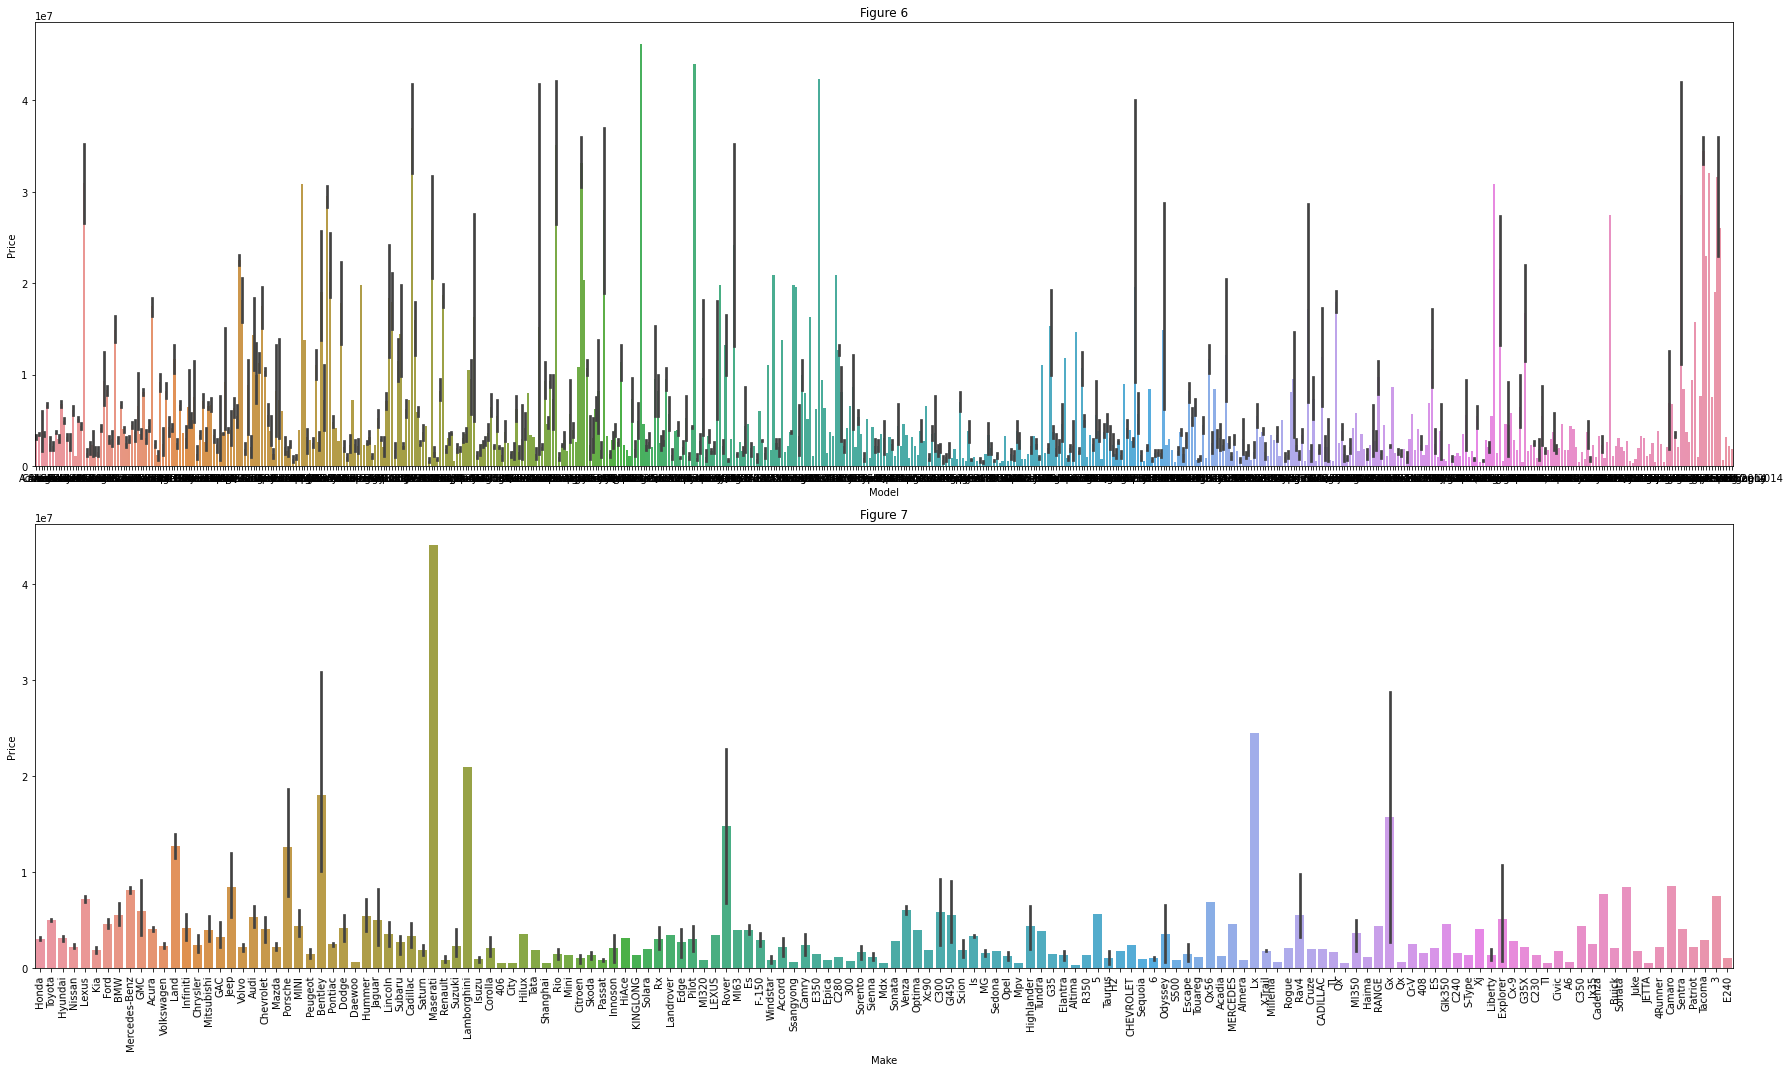

In [84]:
fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(25,15)
sns.barplot(x='Model',y='Price',data=df_new,ax=axs[0])
sns.barplot(x='Make',y='Price',data=df_new,ax=axs[1])
axs[1].set_xticklabels(df_new.Make.unique(),rotation=91)
axs[0].set_title('Figure 6')
axs[1].set_title('Figure 7')
plt.tight_layout()
plt.savefig('Insight-Figure-6-7.jpg',dpi=600)
plt.show()

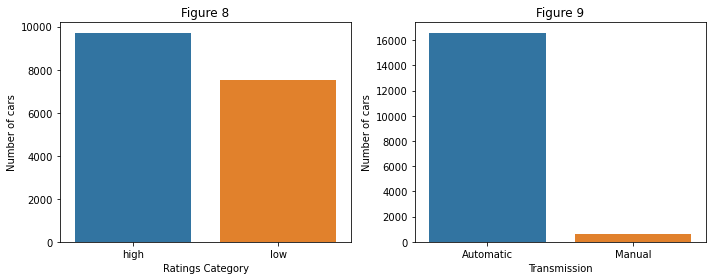

In [85]:
fig,axs=plt.subplots(ncols=2)
fig.set_size_inches(10,4)
sns.barplot(df.groupby('Ratings Category').count()['Price'].index,df.groupby('Ratings Category').count()['Price'].values,ax=axs[0])
sns.barplot(df.groupby('Transmission').count()['Price'].index,df.groupby('Transmission').count()['Price'].values,ax=axs[1])
axs[0].set_ylabel('Number of cars')
axs[0].set_title('Figure 8')
axs[1].set_ylabel('Number of cars')
axs[1].set_title('Figure 9')
plt.tight_layout()
plt.show()

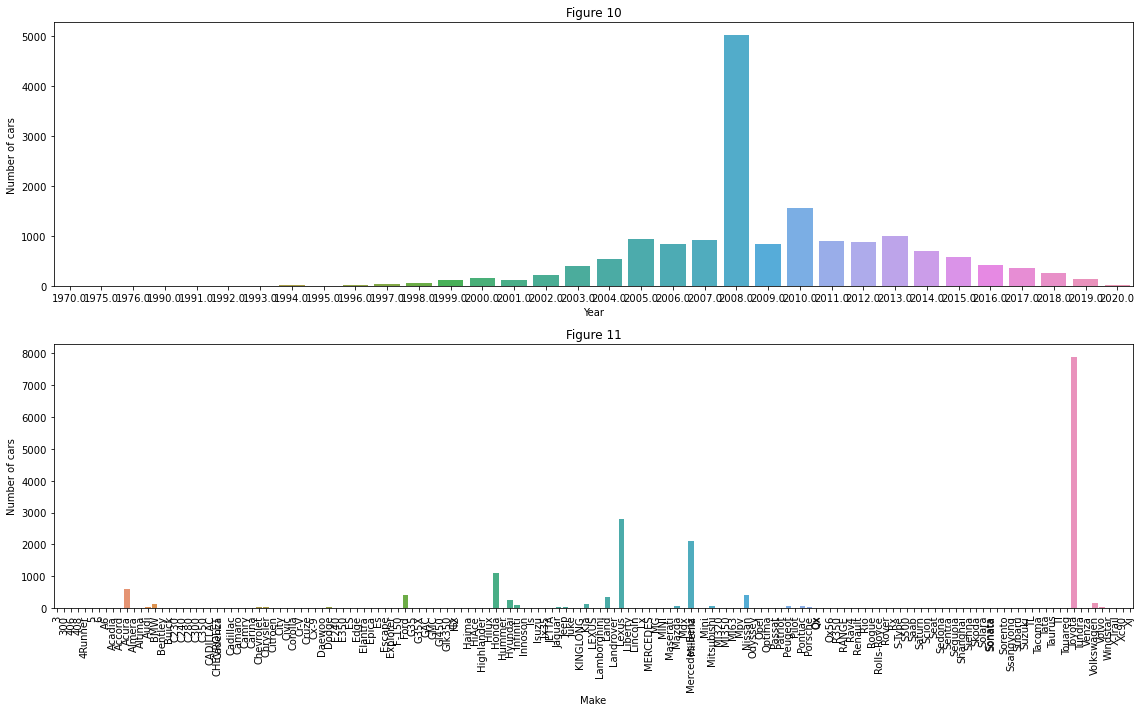

In [86]:
#Number of Cars against the make and year of make

fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(16,10)
sns.barplot(df.groupby('Year').count()['Price'].index,df.groupby('Year').count()['Price'].values,ax=axs[0])
sns.barplot(df.groupby('Make').count()['Price'].index,df.groupby('Make').count()['Price'].values,ax=axs[1])
axs[0].set_ylabel('Number of cars')
axs[0].set_title('Figure 10')
axs[1].set_ylabel('Number of cars')
axs[1].set_title('Figure 11')
axs[1].set_xticklabels(df.groupby('Make').count()['Price'].index,rotation=90)
plt.tight_layout()
plt.show()

# Machine Learning Modelling

In [98]:
# Transforming categorical columns values into integer values using LabelEncoder
df_new = df_new.drop('Id',axis=1)
en = preprocessing.LabelEncoder()
df_new[cat_cols] = df_new[cat_cols].apply(en.fit_transform)
df_new.head(5)

,city,History,Millage,Ratings,Year,Make,Model,Transmission,Age,Price
0,0,0,149232.0,4.7,2015.0,62,91,0,5.0,4965000
1,3,1,145078.0,4.4,2005.0,142,184,0,15.0,1280000
2,3,1,91691.0,4.6,2008.0,142,184,0,12.0,1280000
3,17,1,234797.0,4.5,2004.0,142,184,0,16.0,1567500
4,17,0,145678.0,4.8,2013.0,64,106,0,7.0,6065000


In [101]:
#Scaling Dataset

#Scaling numerical data
norm = StandardScaler()
df_new['Price'] = np.log(df_new['Price'])
df_new['Year'] = norm.fit_transform(np.array(df_new['Year']).reshape(-1,1))
df_new['Model'] = norm.fit_transform(np.array(df_new['Model']).reshape(-1,1))
df_new['city'] = norm.fit_transform(np.array(df_new['city']).reshape(-1,1))

#scaling target variable using Interquantile range
q1, q3 = (df_new['Price'].quantile([0.25,0.75]))
o1 = q1 - 1.5*(q3-q1)
o2 = q3 + 1.5*(q3-q1)
df_new = df_new[(df_new.Price >= o1) & (df_new.Price <= o2)]
df_new.head(5)

,city,History,Millage,Ratings,Year,Make,Model,Transmission,Age,Price
0,-4.799444,0,149232.0,4.7,1.777331,62,-1.376186,0,5.0,1.006325
1,-3.921018,1,145078.0,4.4,-1.204845,142,-0.754663,0,15.0,0.972105
2,-3.921018,1,91691.0,4.6,-0.310192,142,-0.754663,0,12.0,0.972105
3,0.178305,1,234797.0,4.5,-1.503062,142,-0.754663,0,16.0,0.977502
4,0.178305,0,145678.0,4.8,1.180896,64,-1.275941,0,7.0,1.011029


## Helper Functions

In [105]:
#split dataset int training and testing set
def splitDataset(df,n):
    X = df.iloc[:,n]
    y = df.iloc[:,-1:].values.T
    y = y[0]
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)
    return (X_train, X_test, y_train, y_test)

#remove negative values from model predictions
def remove_neg(y_test, y_pred):
    ind = [index for index in range(len(y_pred)) if(y_pred[index]>0)]
    y_pred = y_pred[ind]
    y_test = y_test[ind]
    y_pred[y_pred < 0]
    return (y_test,y_pred)

#function for evaluation of model
def result(y_test,y_pred):
    r=[]
    r.append(mean_squared_log_error(y_test, y_pred))
    r.append(np.sqrt(r[0]))
    r.append(r2_score(y_test,y_pred))
    r.append(round(r2_score(y_test,y_pred)*100,4))
    return (r)

In [106]:
#Split dataset into train and test dataset
X_train, X_test, y_train, y_test = splitDataset(df_new, list(range(len(list(df_new.columns))-1)))

#dataframe that store the performance of each model
score = pd.DataFrame(index = ['MSLE', 'Root MSLE', 'R2 Score','Accuracy(%)'])

### Linear Regression

In [128]:
#fitting model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

#calculating error/accuracy
y_test_1, y_pred_1 = remove_neg(y_test, y_pred)
r1_lr = result(y_test_1,y_pred_1)
print("MSLE : {}".format(r1_lr[0]))
print("Root MSLE : {}".format(r1_lr[1]))
print("R2 Score : {} or {}%".format(r1_lr[2], r1_lr[3]))

#Save Result
score['Linear Regression'] = r1_lr

MSLE : 3.370910360871894e-05
Root MSLE : 0.00580595415144823
R2 Score : 0.53583909212713 or 53.5839%


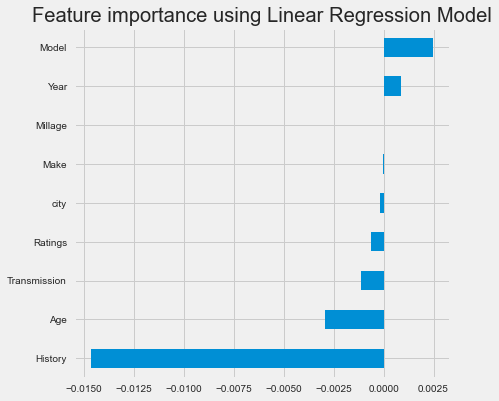

In [129]:
#Feature importance for Linear Regression Model

coef = pd.Series(lr_model.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Linear Regression Model")
plt.savefig('Linear-Regression-Feature-Importance.jpg')
plt.show()

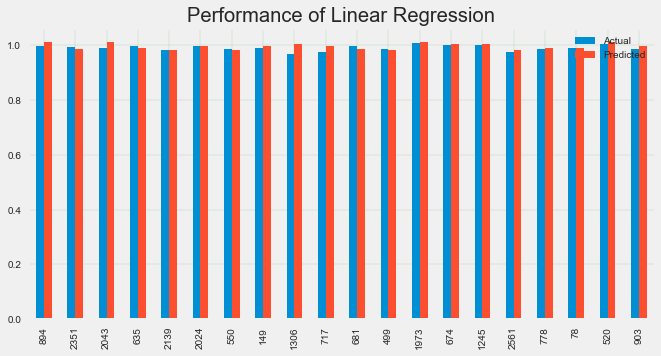

In [130]:
#Visualization of true value and predicted

df_check = pd.DataFrame({'Actual': y_test_1, 'Predicted': y_pred_1})
df_check = df_check.sample(20)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='Green')
plt.title('Performance of Linear Regression')
plt.savefig('Linear-Regression-Performance')
plt.show()

### KNN

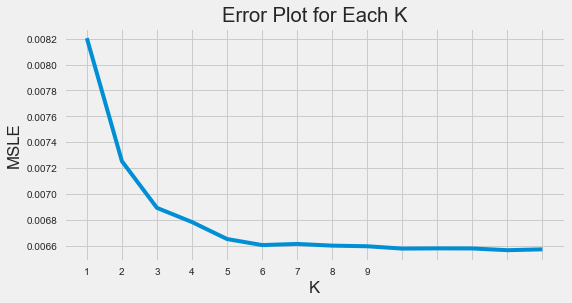

In [131]:
#estimating MSLE for k = 1-15
R_MSLE = []
for i in range(1,15):
    KNN = KNeighborsRegressor(n_neighbors=i)
    KNN.fit(X_train, y_train)
    y_pred = KNN.predict(X_test)
    error = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R_MSLE.append(error)

#plotting error
curve = pd.DataFrame(R_MSLE) #elbow curve 
plt.figure(figsize=(8,4))
plt.xticks(list(range(1,15)), list(range(1,10)), rotation='horizontal')
plt.plot(list(range(1,15)),R_MSLE)
plt.xlabel('K')
plt.ylabel('MSLE')
plt.title('Error Plot for Each K')
plt.savefig('KNN-Error-Plot.jpg')
plt.show()

In [132]:
# fitting model
KNN = KNeighborsRegressor(n_neighbors=6) 
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)

# model evaluation
r4_knn = result(y_test, y_pred)
print("MSLE : {}".format(r4_knn[0]))
print("Root MSLE : {}".format(r4_knn[1]))
print("R2 Score : {} or {}%".format(r4_knn[2],r4_knn[3]))

# save result
score['KNN'] = r4_knn

MSLE : 4.3654433197810576e-05
Root MSLE : 0.006607150157050359
R2 Score : 0.3985960653944788 or 39.8596%


### Random Forest

In [133]:
#fitting model
RF_model = RandomForestRegressor(n_estimators=180,random_state=0, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
RF_model.fit(X_train, y_train)
y_pred = RF_model.predict(X_test)

r5_rf = result(y_test, y_pred)
print("MSLE : {}".format(r5_rf[0]))
print("Root MSLE : {}".format(r5_rf[1]))
print("R2 Score : {} or {}%".format(r5_rf[2],r5_rf[3]))

# save result
score['RandomForest Regressor'] = r5_rf

MSLE : 1.5975075151118457e-05
Root MSLE : 0.003996883179568607
R2 Score : 0.7804737851773922 or 78.0474%


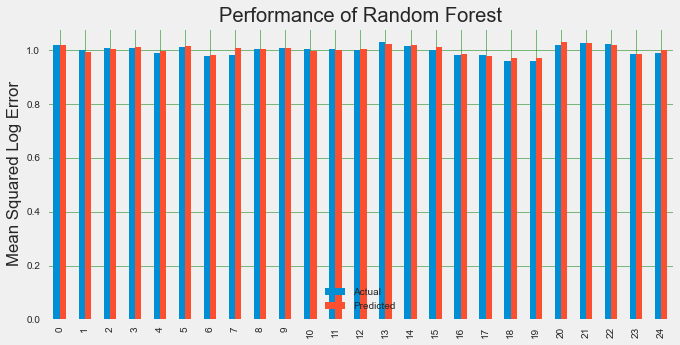

In [134]:
df_check = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_check = df_check.head(25)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title('Performance of Random Forest')
plt.ylabel('Mean Squared Log Error')
plt.savefig('Random-Forest-Performance.jpg')
plt.show()

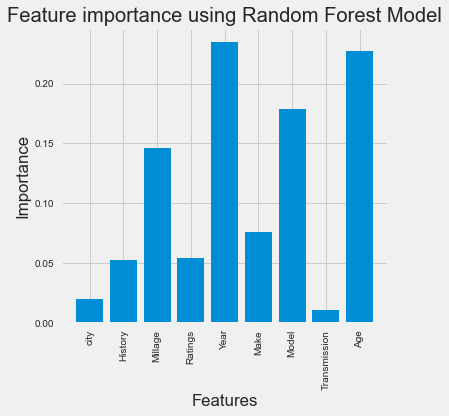

In [135]:
importances = RF_model.feature_importances_
features = X_train.columns

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.figure(figsize=(6,6))
plt.bar(x_values, importances, orientation = ('vertical'))
# Tick labels for x axis
plt.xticks(x_values, features, rotation=(90))
# Axis labels and title
plt.ylabel('Importance'); 
plt.xlabel('Features'); 
plt.title('Feature importance using Random Forest Model')
plt.tight_layout()
plt.savefig('Random-Forest-Features-Importances.jpg',dpi=600)
plt.show();

### Adaboost

In [144]:
# fitting model
AB_model = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=24),
    n_estimators=200,learning_rate=0.6
)

AB_model.fit(X_train, y_train)
y_pred = AB_model.predict(X_test)

#model evaluation
r7_ab = result(y_test, y_pred)
print("MSLE : {}".format(r7_ab[0]))
print("Root MSLE : {}".format(r7_ab[1]))
print("R2 Score : {} or {}%".format(r7_ab[2],r7_ab[3]))

MSLE : 1.7328104937792858e-05
Root MSLE : 0.004162704041580768
R2 Score : 0.7617328616915267 or 76.1733%


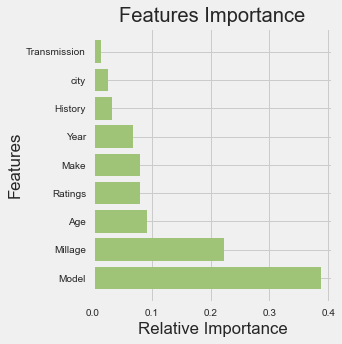

In [145]:
importances = AB_model.feature_importances_
features = X_train.columns

indices = np.argsort(importances)
indices = [x for x in reversed(indices)]
plt.figure(1)
plt.title('Features Importance')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('Adaboost-Features-Importance.jpg',dpi=60)
plt.show();

In [146]:
#Save AdaBoost Result
score['AdaBoost Regressor'] = r7_ab

### XGBOOST

In [136]:
#fitting model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.4,
                          max_depth = 24, alpha = 5, n_estimators = 200)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)


#model evaluation
y_test_1, y_pred_1 = remove_neg(y_test,y_pred)
r8_xg = result(y_test_1,y_pred_1)
print("MSLE : {}".format(r8_xg[0]))
print("Root MSLE : {}".format(r8_xg[1]))
print("R2 Score : {} or {}%".format(r8_xg[2],r8_xg[3]))

MSLE : 2.541449757628078e-05
Root MSLE : 0.005041279359079477
R2 Score : 0.6499349191155182 or 64.9935%


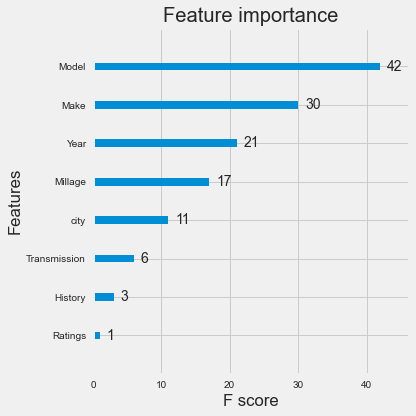

In [137]:
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.tight_layout()
plt.savefig('XGBoost-Features-Importance.jpg')
plt.show();

In [138]:
#Save XGBoost Result
score['XGBoost Regressor']=r8_xg

## Result Evaluation

In [147]:
# Save Results
score.to_csv('result_evaluation.csv')

In [148]:
# Display Results
score = pd.read_csv('./result_evaluation.csv',index_col=0)
score

,Linear Regression,KNN,RandomForest Regressor,XGBoost Regressor,AdaBoost Regressor
MSLE,0.000034,0.000044,0.000016,0.000025,0.000017
Root MSLE,0.005806,0.006607,0.003997,0.005041,0.004163
R2 Score,0.535839,0.398596,0.780474,0.649935,0.761733
Accuracy(%),53.583900,39.859600,78.047400,64.993500,76.173300
